# Quote Generator: Next Word Prediction with GRU

## Introduction
Text generation is one of the most fascinating applications of Deep Learning. In this notebook, we will build a **Next Word Predictor** using a **Gated Recurrent Unit (GRU)** neural network. 

We will train the model on a dataset of quotes to learn the structure of language and generate inspiring (or sometimes philosophical) new quotes.

### Workflow:
1. **Data Loading & Cleaning**: Preprocessing raw text.
2. **Tokenization**: Converting text into numerical sequences.
3. **Dataset Creation**: Creating n-gram sequences for supervised learning.
4. **Model Architecture**: Building an Embedding + GRU + Dense model.
5. **Training**: Training with callbacks for optimal performance.
6. **Inference**: Generating new quotes with temperature sampling.

## 1. Imports and Setup
First, we import the necessary libraries. We'll use `tensorflow.keras` for building the model and `pandas` for handling the data.

In [105]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import logging

# 1. Hide only low-level C++ logs (CUDA, XLA, cuDNN, cuBLAS)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  
# 2. Keep Python-side logs visible
logging.getLogger("tensorflow").setLevel(logging.INFO)
import tensorflow as tf
# 3. Explicitly re-enable training/compilation messages
tf.get_logger().setLevel("INFO")

# TensorFlow Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

# Set style for plots
sns.set_style("whitegrid")

## 2. Data Loading
We load the dataset containing quotes. We'll inspect the first few rows to understand the structure.

In [106]:
df = pd.read_csv("/kaggle/input/quote-dataset/Quote_data.csv")
df.head()

,Quote,Author,Tags,revised_tags
0,“Be yourself; everyone else is already taken.”,Oscar Wilde,"attributed-no-source, be-yourself, gilbert-per...","['attributed-no-source', 'be-yourself', 'hones..."
1,“You've gotta dance like there's nobody watchi...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love...","['dance', 'heaven', 'hurt', 'inspirational', '..."
2,“Be the change that you wish to see in the wor...,Mahatma Gandhi,"action, change, inspirational, misattributed-t...","['action', 'change', 'inspirational', 'philoso..."
3,“Darkness cannot drive out darkness: only ligh...,"Martin Luther King Jr., A Testament of Hope: ...","darkness, drive-out, hate, inspirational, ligh...","['darkness', 'hate', 'inspirational', 'light',..."
4,“Live as if you were to die tomorrow. Learn as...,Mahatma Gandhi,"carpe-diem, education, inspirational, learning","['carpe-diem', 'education', 'inspirational', '..."


## 3. Data Cleaning and Preprocessing
Raw text data is messy. To train a good model, we need to clean it:
- Drop unnecessary columns.
- Remove null values.
- Convert all text to **lowercase**.
- Remove **punctuation** to reduce vocabulary noise.

In [107]:
# Keep only relevant columns
if 'Tags' in df.columns:
    df.drop(['Tags', 'revised_tags'], axis=1, inplace=True)

quotes = df['Quote'].copy()

# Remove null values
quotes = quotes.dropna()

# Convert to lowercase
quotes = quotes.str.lower()

# Remove punctuation
quotes = quotes.str.translate(str.maketrans('', '', string.punctuation))

print(f"Total quotes after cleaning: {len(quotes)}")

Total quotes after cleaning: 29355


### Smart Filtering
Extremely short quotes don't provide enough context, and extremely long ones can be outliers. We filter the dataset to keep quotes within a reasonable length range (roughly 4 to 60 words).

In [108]:
# Calculate word counts
quote_lengths = quotes.str.split().str.len()

# Filter: Keep quotes between 4 and 60 words
quotes = quotes[(quote_lengths >= 4) & (quote_lengths <= 60)]
quotes = quotes.reset_index(drop=True)

print(f"After length filtering: {len(quotes):,} quotes")
print(f"Average quote length: {quotes.str.split().str.len().mean():.1f} words")
quotes.head()

After length filtering: 24,027 quotes
Average quote length: 23.7 words


0         “be yourself everyone else is already taken”
1    “youve gotta dance like theres nobody watching...
2    “be the change that you wish to see in the world”
3    “darkness cannot drive out darkness only light...
4    “live as if you were to die tomorrow learn as ...
Name: Quote, dtype: object

In [109]:
from collections import Counter
import pandas as pd
import numpy as np

# FUNCTION: Clean Corpus
def clean_corpus(corpus, min_frequency=2):
    """Remove words appearing less than min_frequency times"""
    all_words = []
    for text in corpus:
        all_words.extend(text.split())
    
    word_freq = Counter(all_words)
    total_unique = len(word_freq)
    rare_words = sum(1 for c in word_freq.values() if c < min_frequency)
    
    cleaned_corpus = []
    total_words_removed = 0
    
    for text in corpus:
        words = text.split()
        filtered_words = [w for w in words if word_freq[w] >= min_frequency]
        cleaned_corpus.append(' '.join(filtered_words))
        total_words_removed += len(words) - len(filtered_words)
    
    print("=" * 70)
    print("🧹 CORPUS CLEANING RESULTS")
    print("=" * 70)
    print(f"   Min frequency threshold: {min_frequency}")
    print(f"   Original unique words: {total_unique:,}")
    print(f"   Rare words removed: {rare_words:,} ({rare_words/total_unique*100:.1f}%)")
    print(f"   Words kept: {total_unique - rare_words:,}")
    print(f"   Occurrences removed: {total_words_removed:,}")
    print(f"   Occurrences kept: {len(all_words) - total_words_removed:,}")
    
    # Show sample of removed words
    removed_words = {w: c for w, c in word_freq.items() if c < min_frequency}
    if removed_words:
        sorted_removed = sorted(removed_words.items(), key=lambda x: (-x[1], x[0]))[:20]
        print(f"\n   📋 Sample of removed words (top 20):")
        for word, count in sorted_removed:
            print(f"      '{word}' → {count}x")
    
    return cleaned_corpus, word_freq



print("\nOPTIMIZED VOCABULARY ANALYSIS FOR LITERARY QUOTES")
corpus = quotes
print("\nCleaning Corpus")
cleaned_corpus, original_freq = clean_corpus(corpus, min_frequency=2)


OPTIMIZED VOCABULARY ANALYSIS FOR LITERARY QUOTES

Cleaning Corpus
🧹 CORPUS CLEANING RESULTS
   Min frequency threshold: 2
   Original unique words: 36,236
   Rare words removed: 19,097 (52.7%)
   Words kept: 17,139
   Occurrences removed: 19,097
   Occurrences kept: 549,857

   📋 Sample of removed words (top 20):
      '101' → 1x
      '1010300' → 1x
      '1013' → 1x
      '103”' → 1x
      '1050' → 1x
      '10m' → 1x
      '10”' → 1x
      '113”' → 1x
      '1153a' → 1x
      '1155' → 1x
      '118' → 1x
      '11th' → 1x
      '11”' → 1x
      '12000year' → 1x
      '123' → 1x
      '128”' → 1x
      '1291901”' → 1x
      '13' → 1x
      '1346' → 1x
      '140' → 1x


## 4. Tokenization
Computers understand numbers, not words. We use `Tokenizer` to:
- Map each unique word to a unique integer.
- Limit the vocabulary size to the top frequent words to keep the model efficient.

In [111]:
vocab_size = 8000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(cleaned_corpus)

word_index = tokenizer.word_index
actual_vocab_size = min(vocab_size,len(word_index)) + 1

print(f"Total unique words: {len(word_index)}")
print(f"Top 10 words: {list(word_index.items())[:10]}")
print(f"Actual vocab size: {actual_vocab_size}")

Total unique words: 17140
Top 10 words: [('<UNK>', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('is', 6), ('a', 7), ('you', 8), ('in', 9), ('that', 10)]
Actual vocab size: 8001


## 5. Preparing Input Sequences
We treat this as a supervised learning problem:
- **Input (X)**: A sequence of words (e.g., "life is a").
- **Label (y)**: The next word (e.g., "journey").

We create N-gram sequences from the text. For a sentence "A B C", we create:
- [A] -> B
- [A, B] -> C

In [112]:
sequences = tokenizer.texts_to_sequences(quotes)

X = []
y = []
max_sequence_len = 60

for seq in sequences:
    if len(seq) > 1:
        # Create sliding window sequences
        for i in range(1, min(len(seq), max_sequence_len)):
            input_seq = seq[:i]
            output_seq = seq[i]
            X.append(input_seq)
            y.append(output_seq)

print(f"Total training sequences: {len(X)}")

Total training sequences: 544924


### Padding
Sequences must be the same length for the neural network. We pad shorter sequences with zeros at the beginning (`padding='pre'`).

In [113]:
max_len = max(len(x) for x in X) + 1  # Maximum sequence length found
X_padded = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

print(f"Max Sequence Length: {max_len}")
print(f"Input Shape: {X_padded.shape}")

Max Sequence Length: 60
Input Shape: (544924, 60)


## 6. Model Architecture (GRU)
We use a **Gated Recurrent Unit (GRU)**, which is efficient for sequence modeling.

- **Embedding Layer**: Converts integer tokens into dense vectors. `mask_zero=True` tells the layer to ignore padding.
- **GRU Layer**: Captures temporal dependencies (context) in the text.
- **Dropout**: Prevents overfitting by randomly turning off neurons.
- **Dense Output**: A softmax layer predicting the probability of the next word across the entire vocabulary.

In [116]:
model = Sequential([
    # Embedding layer: specific output dim 128
    Embedding(actual_vocab_size, 256, mask_zero=True),
    # Dropout
    Dropout(0.2),
    # GRU layer with dropout for regularization
    GRU(256, dropout=0.1,recurrent_dropout=0.2,use_cudnn=False),
    # Additional Dropout
    Dropout(0.2),
    # Output layer: Predict probability for every word in vocab
    Dense(actual_vocab_size, activation='softmax')
])

# Compile the model
# We use SparseTopKCategoricalAccuracy to track if the true word was in the top 3 or 5 predictions
optimizer = Adam(learning_rate=0.001, clipnorm=1.0) # clipnorm prevents exploding gradients
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseTopKCategoricalAccuracy(k=3, name='top_3_acc')]
)

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_18 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 7. Training
We use callbacks to optimize training:
- **ModelCheckpoint**: Saves the best model based on validation loss.
- **EarlyStopping**: Stops training if the validation loss stops improving.
- **ReduceLROnPlateau**: Lowers the learning rate when progress stalls.

In [117]:
callbacks = [
    ModelCheckpoint('best_quote_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
]

# Train the model
history = model.fit(
        X_padded, y,
        validation_split=0.2,
        epochs=100,
       batch_size = 1024,
        callbacks=callbacks,
        verbose=1
)

Epoch 1/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0621 - loss: 6.8580 - top_3_acc: 0.1296
Epoch 1: val_loss improved from inf to 6.30594, saving model to best_quote_model.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.0622 - loss: 6.8571 - top_3_acc: 0.1297 - val_accuracy: 0.0975 - val_loss: 6.3059 - val_top_3_acc: 0.1838 - learning_rate: 0.0010
Epoch 2/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0745 - loss: 6.2426 - top_3_acc: 0.1546
Epoch 2: val_loss improved from 6.30594 to 6.19212, saving model to best_quote_model.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.0745 - loss: 6.2425 - top_3_acc: 0.1546 - val_accuracy: 0.1033 - val_loss: 6.1921 - val_top_3_acc: 0.2027 - learning_rate: 0.0010
Epoch 3/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0842 - loss: 6.1304 - top_3_acc: 0.1717
Epoch 3: val_loss improved from 6.19212 to 6.05875, saving model to best_quote_model.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 31s 

## 8. Training Results & Visualization
Let's visualize the training and validation accuracy/loss to check for overfitting.

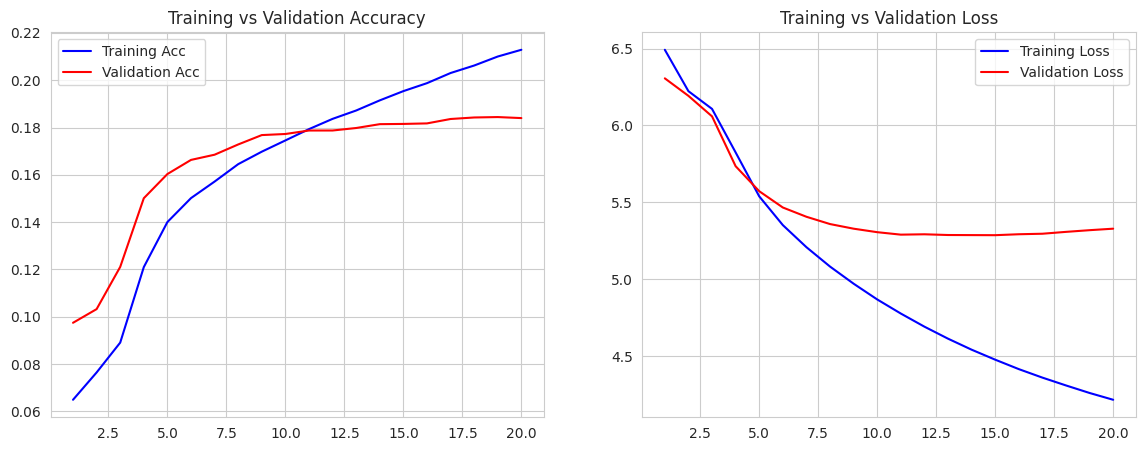

In [118]:
# Plotting Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Acc')
plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

## 9. Generating Quotes
Now for the fun part! We generate quotes using the trained model.

We use a **Temperature** parameter to control randomness:
- **Low (e.g., 0.2)**: Deterministic, safe, repetitive.
- **High (e.g., 1.2)**: Creative, diverse, but can be incoherent.
- **Top-K Sampling**: We restrict predictions to the top K most likely words to prevent nonsense tokens.

In [127]:
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

def generate_quote(seed_text, next_words=20, temperature=1.0, top_k=50):
    result = seed_text.lower()
    
    for _ in range(next_words):
        # Tokenize and pad the current sequence
        token_list = tokenizer.texts_to_sequences([result])[0]
        token_list = pad_sequences([token_list], maxlen=max_len, padding='pre')
        
        # Get probabilities
        predictions = model.predict(token_list, verbose=0)[0]
        
        # Avoid <PAD> (0) and <UNK> (1)
        predictions[0] = 0
        predictions[1] = 0
        
        # Top-K Sampling
        top_k_indices = np.argsort(predictions)[-top_k:]
        top_k_probs = predictions[top_k_indices]
        
        # Apply Temperature
        top_k_probs = np.power(top_k_probs, 1/temperature)
        top_k_probs = top_k_probs / top_k_probs.sum()  # Normalize
        
        # Randomly choose based on new probabilities
        predicted_id = np.random.choice(top_k_indices, p=top_k_probs)
        output_word = reverse_word_index.get(predicted_id, "")
        
        if not output_word or output_word in ['<UNK>', '<PAD>']:
            break
            
        result += " " + output_word
    
    return result

# Test with different temperatures
seeds = ["life is", "love is","successfull","yesterday is"]

print("--- Generated Quotes ---")
for seed in seeds:
    print(f"\nSeed: '{seed}'")
    print(f"Balanced: {generate_quote(seed, temperature=0.7)}")
    # print(f"Creative: {generate_quote(seed, temperature=1.2)}")

--- Generated Quotes ---

Seed: 'life is'
Balanced: life is the most important thing is the kind of the right of life is not a fact that you can see

Seed: 'love is'
Balanced: love is a man in the world what he was a philosopher who does not the time of the world the mind

Seed: 'successfull'
Balanced: successfull is a little thing you have noticed of yourself” people who have ever met it on the ground” of the

Seed: 'yesterday is'
Balanced: yesterday is never seen the truth and the point is the only thing which is so that life is worth living” and


## 10. Saving Model and Important Params

In [120]:
# Save the model
model.save('quote_generator_model.keras')

# Save the tokenizer
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save important parameters
import json
model_params = {
    'max_len': int(max_len),
    'actual_vocab_size': int(actual_vocab_size),
}

with open('model_params.json', 'w') as f:
    json.dump(model_params, f, indent=2)

# Save training history
history_dict = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']]
}

with open('training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

print("✅ quote_generator_model.keras")
print("✅ best_quote_generator_model.keras (saved during training)")
print("✅ tokenizer.pkl")
print("✅ model_params.json")
print("✅ training_history.json")


print("✅ Model saved successfully!")
print("✅ Tokenizer saved successfully!")
print("✅ Parameters saved successfully!")

✅ quote_generator_model.keras
✅ best_quote_generator_model.keras (saved during training)
✅ tokenizer.pkl
✅ model_params.json
✅ training_history.json
✅ Model saved successfully!
✅ Tokenizer saved successfully!
✅ Parameters saved successfully!
